In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from os import makedirs
makedirs("data/Train_Skies/Train_Skies", exist_ok=True)

from urllib.request import urlretrieve
# データのダウンロード
urlretrieve("https://git.io/vXLqk", "data/Train_Skies/Train_Skies/Training_Sky3.csv")
# draw_sky2.pyのダウンロード
urlretrieve("https://git.io/vXLqU", "draw_sky2.py")

('draw_sky2.py', <http.client.HTTPMessage at 0x117c7bc50>)

Data on galaxies in sky 3.
position_x, position_y, e_1, e_2 
[[  1.62690000e+02   1.60006000e+03   1.14664000e-01  -1.90326000e-01]
 [  2.27228000e+03   5.40040000e+02   6.23555000e-01   2.14979000e-01]
 [  3.55364000e+03   2.69771000e+03   2.83527000e-01  -3.01870000e-01]]


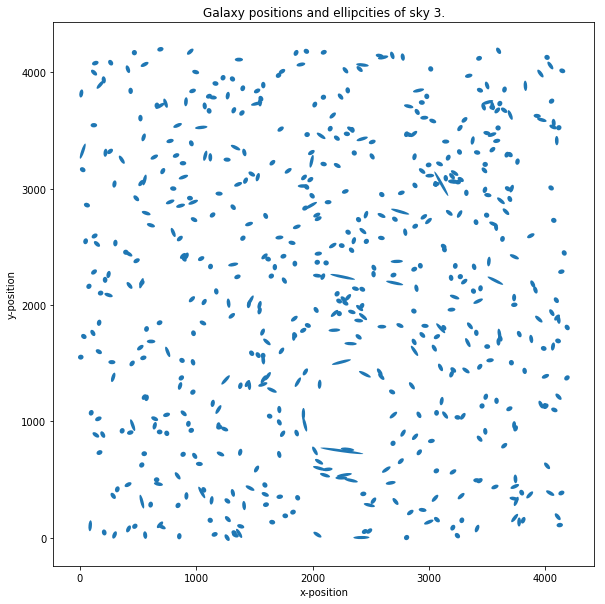

In [3]:
from draw_sky2 import draw_sky

n_sky = 3  # choose a file/sky to examine.
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype=None,
                      skip_header=1,
                      delimiter=",",
                      usecols=[1, 2, 3, 4])
print("Data on galaxies in sky %d." % n_sky)
print("position_x, position_y, e_1, e_2 ")
print(data[:3])

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position");

In [4]:
def euclidean_distance(x, y):
    return np.sqrt(((x - y) ** 2).sum(axis=1))


def f_distance(gxy_pos, halo_pos, c):
    # foo_position should be a 2-d numpy array
    return np.maximum(euclidean_distance(gxy_pos, halo_pos), c)[:, None]


def tangential_distance(glxy_position, halo_position):
    # foo_position should be a 2-d numpy array
    delta = glxy_position - halo_position
    t = (2 * np.arctan(delta[:, 1] / delta[:, 0]))[:, None]
    return np.concatenate([-np.cos(t), -np.sin(t)], axis=1)

import pymc as pm

# set the size of the halo's mass
mass_large = pm.Uniform("mass_large", 40, 180, trace=False)

# set the initial prior position of the halos, it's a 2-d Uniform dist.
halo_position = pm.Uniform("halo_position", 0, 4200, size=(1, 2))


@pm.deterministic
def mean(mass=mass_large, h_pos=halo_position, glx_pos=data[:, :2]):
    return mass / f_distance(glx_pos, h_pos, 240) *\
        tangential_distance(glx_pos, h_pos)

In [5]:
ellpty = pm.Normal("ellipcity", mean, 1. / 0.05, observed=True,
                   value=data[:, 2:])
mcmc = pm.MCMC([ellpty, mean, halo_position, mass_large])
map_ = pm.MAP([ellpty, mean, halo_position, mass_large])
map_.fit()
mcmc.sample(200000, 140000, 3)

 [-----------------100%-----------------] 200000 of 200000 complete in 87.7 sec

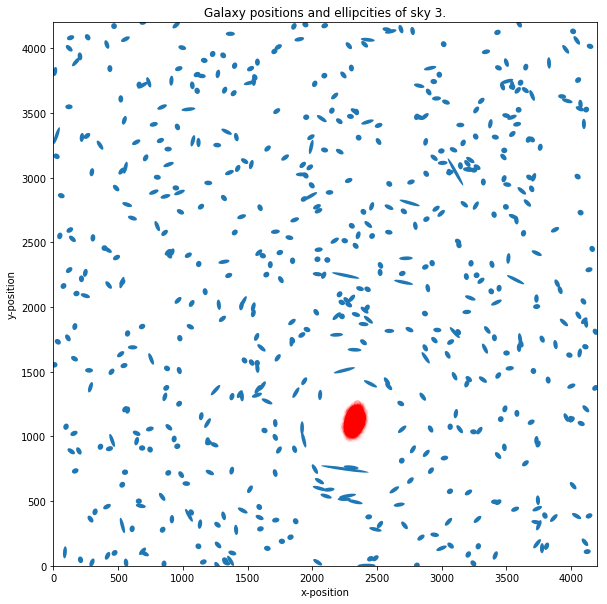

In [6]:
t = mcmc.trace("halo_position")[:].reshape(20000, 2)

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:, 0], t[:, 1], alpha=0.015, c="r")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

In [7]:
from os import makedirs
makedirs("data", exist_ok=True)

from urllib.request import urlretrieve
# データのダウンロード
urlretrieve("https://git.io/vXLm6", "data/Training_halos.csv")

('data/Training_halos.csv', <http.client.HTTPMessage at 0x118613320>)

In [8]:
halo_data = np.genfromtxt("data/Training_halos.csv",
                          delimiter=",",
                          usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9],
                          skip_header=1)
print(halo_data[n_sky])

[  1.00000000e+00   1.40861000e+03   1.68586000e+03   1.40861000e+03
   1.68586000e+03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


True halo location: 1408.61 1685.86


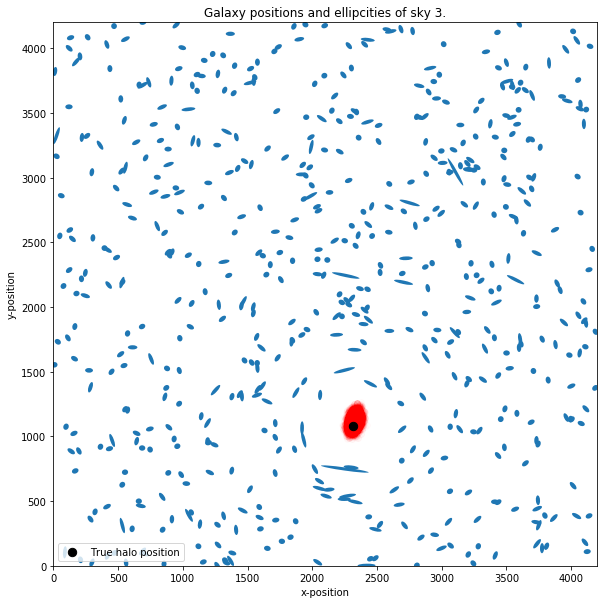

In [9]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:, 0], t[:, 1], alpha=0.015, c="r")
plt.scatter(halo_data[n_sky - 1][3], halo_data[n_sky - 1][4],
            label="True halo position",
            c="k", s=70)
plt.legend(scatterpoints=1, loc="lower left")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

print("True halo location:", halo_data[n_sky][3], halo_data[n_sky][4])

In [10]:
mean_posterior = t.mean(axis=0).reshape(1, 2)
print(mean_posterior)

[[ 2324.0135091   1122.26395225]]


In [11]:
from urllib.request import urlretrieve
# DarkWorldsMetric.pyのダウンロード
urlretrieve("https://git.io/vXLmx", "DarkWorldsMetric.py")

('DarkWorldsMetric.py', <http.client.HTTPMessage at 0x12ad4fbe0>)

In [12]:
from DarkWorldsMetric import main_score

_halo_data = halo_data[n_sky - 1]

nhalo_all = _halo_data[0].reshape(1, 1)
x_true_all = _halo_data[3].reshape(1, 1)
y_true_all = _halo_data[4].reshape(1, 1)
x_ref_all = _halo_data[1].reshape(1, 1)
y_ref_all = _halo_data[2].reshape(1, 1)
sky_prediction = mean_posterior

print("Using the mean:")
main_score(nhalo_all, x_true_all, y_true_all,
           x_ref_all, y_ref_all, sky_prediction)

print("\n")
# what's a bad score?
random_guess = np.random.randint(0, 4200, size=(1, 2))
print("Using a random location:", random_guess)
main_score(nhalo_all, x_true_all, y_true_all,
           x_ref_all, y_ref_all, random_guess)

Using the mean:
Your average distance in pixels you are away from the true halo is 41.146147066
Your average angular vector is 1.0
Your score for the training data is 1.04114614707


Using a random location: [[3961 1337]]
Your average distance in pixels you are away from the true halo is 1664.87217254
Your average angular vector is 1.0
Your score for the training data is 2.66487217254


2.6648721725405826

In [13]:
from os import makedirs
makedirs("data/Train_Skies/Train_Skies", exist_ok=True)

from urllib.request import urlretrieve
# データのダウンロード
urlretrieve("https://git.io/vXqk4", "data/Train_Skies/Train_Skies/Training_Sky215.csv")

('data/Train_Skies/Train_Skies/Training_Sky215.csv',
 <http.client.HTTPMessage at 0x12b30ba20>)

In [14]:
from pymc.Matplot import plot as mcplot


def halo_posteriors(n_halos_in_sky, galaxy_data,
                    samples=5e5, burn_in=34e4, thin=4):
    # set the size of the halo's mass
    """
    exp_mass_large = pm.Uniform("exp_mass_large", 40, 180)
    @pm.deterministic
    def mass_large(exp_mass_large = exp_mass_large):
        return np.log(exp_mass_large)
    """

    mass_large = pm.Uniform("mass_large", 40, 180)

    mass_small_1 = 20
    mass_small_2 = 20

    masses = np.array([mass_large, mass_small_1, mass_small_2], dtype=object)

    # set the initial prior positions of the halos, it's a 2-d Uniform dist.
    halo_positions = pm.Uniform("halo_positions", 0, 4200,
                                size=(n_halos_in_sky, 2))  # notice this size

    fdist_constants = np.array([240, 70, 70])

    @pm.deterministic
    def mean(mass=masses, h_pos=halo_positions, glx_pos=data[:, :2],
             n_halos_in_sky=n_halos_in_sky):

        _sum = 0
        for i in range(n_halos_in_sky):
            _sum += mass[i] / f_distance(glx_pos, h_pos[i, :], fdist_constants[i]) *\
                tangential_distance(glx_pos, h_pos[i, :])

        return _sum

    ellpty = pm.Normal("ellipcity", mean, 1. / 0.05, observed=True,
                       value=data[:, 2:])

    map_ = pm.MAP([ellpty, mean, halo_positions, mass_large])
    map_.fit(method="fmin_powell")

    mcmc = pm.MCMC([ellpty, mean, halo_positions, mass_large])
    mcmc.sample(samples, burn_in, thin)
    return mcmc.trace("halo_positions")[:]

In [15]:
n_sky = 215
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype=None,
                      skip_header=1,
                      delimiter=",",
                      usecols=[1, 2, 3, 4])

In [16]:
# there are 3 halos in this file.
samples = 10.5e5
traces = halo_posteriors(3, data, samples=samples,
                         burn_in=9.5e5,
                         thin=10)

/Users/Tomohisa/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 1050000 of 1050000 complete in 779.4 sec

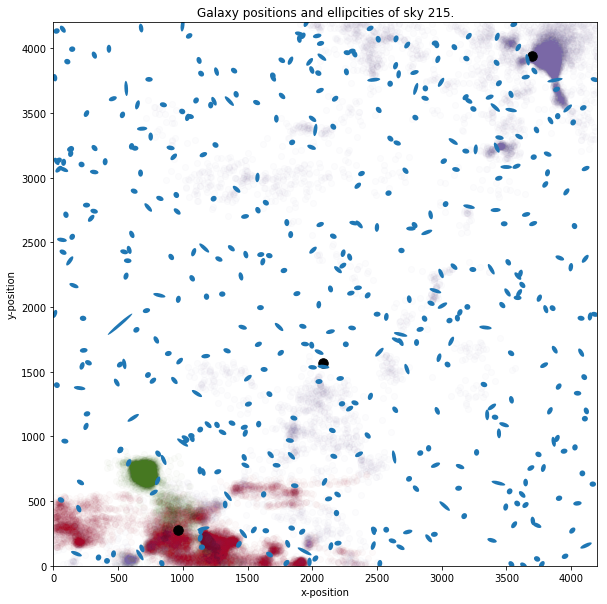

In [17]:

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")

colors = ["#467821", "#A60628", "#7A68A6"]

for i in range(traces.shape[1]):
    plt.scatter(traces[:, i, 0], traces[:, i, 1], c=colors[i], alpha=0.02)


for i in range(traces.shape[1]):
    plt.scatter(halo_data[n_sky - 1][3 + 2 * i], halo_data[n_sky - 1][4 + 2 * i],
                label="True halo position",
                c="k", s=90)

# plt.legend(scatterpoints = 1)
plt.xlim(0, 4200)
plt.ylim(0, 4200);

In [18]:
_halo_data = halo_data[n_sky - 1]
print(traces.shape)

mean_posterior = traces.mean(axis=0).reshape(1, 6)
print(mean_posterior)


nhalo_all = _halo_data[0].reshape(1, 1)
x_true_all = _halo_data[3].reshape(1, 1)
y_true_all = _halo_data[4].reshape(1, 1)
x_ref_all = _halo_data[1].reshape(1, 1)
y_ref_all = _halo_data[2].reshape(1, 1)
sky_prediction = mean_posterior


print("Using the mean:")
main_score([1], x_true_all, y_true_all,
           x_ref_all, y_ref_all, sky_prediction)

# what's a bad score?
print("\n")
random_guess = np.random.randint(0, 4200, size=(1, 2))
print("Using a random location:", random_guess)
main_score([1], x_true_all, y_true_all,
           x_ref_all, y_ref_all, random_guess)

(10000, 3, 2)
[[  784.02735783   603.59554211  1063.43360546   211.74709556
   3132.73488854  3123.25718197]]
Using the mean:
Your average distance in pixels you are away from the true halo is 4430.26997235
Your average angular vector is 1.0
Your score for the training data is 5.43026997235


Using a random location: [[2419 1753]]
Your average distance in pixels you are away from the true halo is 2534.50296794
Your average angular vector is 1.0
Your score for the training data is 3.53450296794


3.5345029679406577